<a href="https://colab.research.google.com/github/basshopee/net_rate/blob/main/net_rate.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [51]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns
from  scipy.stats import skew, kurtosis
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.preprocessing import MinMaxScaler

# deep learning
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

In [52]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [53]:
df = pd.read_csv('/content/drive/My Drive/net_rate/net_rate_only.csv')
df = df.drop(['type'],axis=1)
df.rename(columns={'value':'net_rate'}, inplace=True)
columns_titles = ["grass_date","net_rate"]
df=df.reindex(columns=columns_titles)
df1 = df
df['grass_date']= pd.to_datetime(df['grass_date'])
df = df.set_index(['grass_date'])
df = df.sort_index()
df

,net_rate
grass_date,
2019-01-01,0.808311
2019-01-02,0.808311
2019-01-03,0.808311
2019-01-04,0.808311
2019-01-05,0.808311
...,...
2021-06-12,0.888724
2021-06-13,0.888804
2021-06-14,0.898944


In [54]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 897 entries, 2019-01-01 to 2021-06-16
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   net_rate  897 non-null    float64
dtypes: float64(1)
memory usage: 14.0 KB


# Data Visualisation

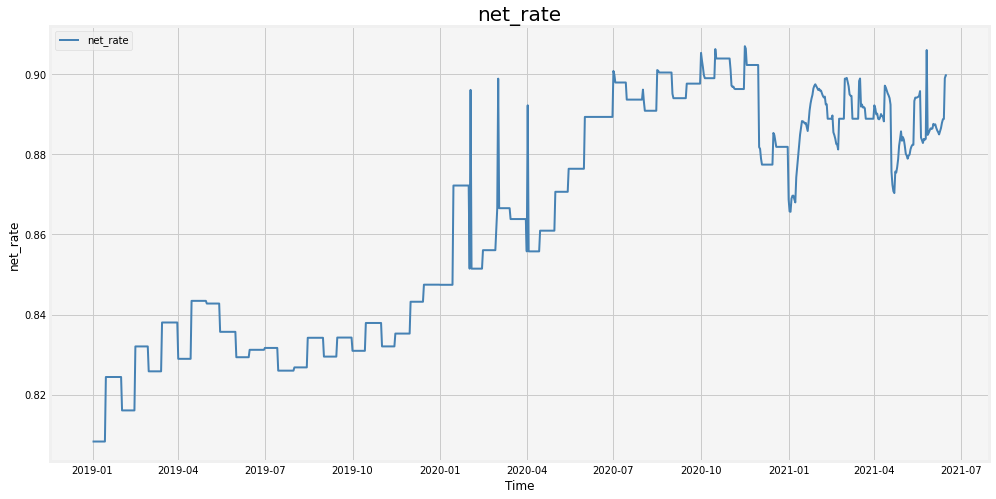

In [55]:
# Plot Data
plt.style.use('fivethirtyeight')
%matplotlib inline

plt.rcParams['axes.unicode_minus']=False
plt.rcParams['figure.figsize'] = (15.0, 8) # set the size of figure
plt.subplot(facecolor = "whitesmoke") # set the background color
plt.plot(df['net_rate'],label = 'net_rate',color="steelblue", linestyle="-", linewidth=2.0) # plot with set the line width,shape and color
plt.legend()

plt.xlabel("Time")
plt.ylabel("net_rate")
plt.title("net_rate", fontsize = 20)
#plt.grid(color="k", linestyle=":") # set grid and line shape

# plt.savefig('Daily cases.png')
plt.show()

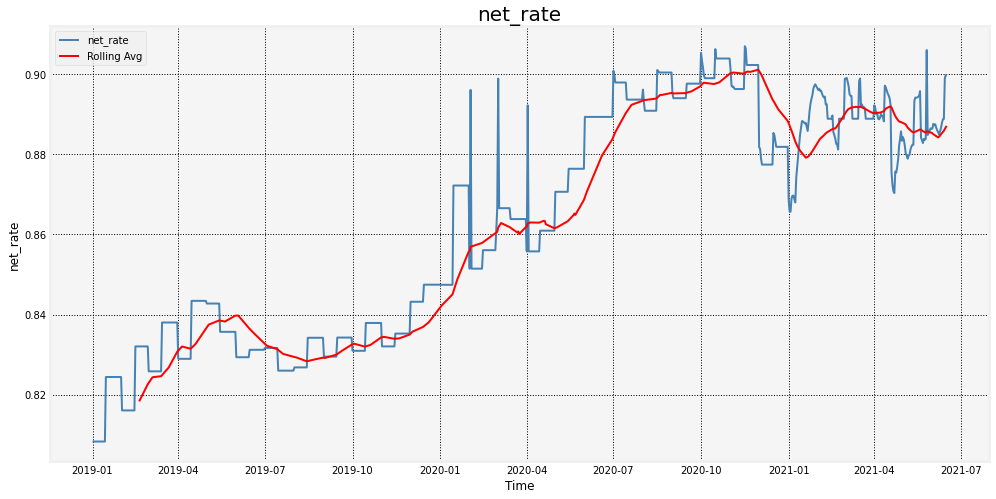

In [56]:
# Rolling Average
df_roll = df.rolling(window=50).mean()

# Plot Data
plt.style.use('fivethirtyeight')
%matplotlib inline

plt.rcParams['axes.unicode_minus']=False
plt.rcParams['figure.figsize'] = (15.0, 8) # set the size of figure
plt.subplot(facecolor = "whitesmoke") # set the background color
plt.plot(df['net_rate'],label = 'net_rate',color="steelblue", linestyle="-", linewidth=2.0) # plot with set the line width,shape and color
plt.plot(df_roll['net_rate'], label = 'Rolling Avg', color="Red", linewidth=2.0)
plt.legend()

plt.xlabel("Time")
plt.ylabel("net_rate")
plt.title("net_rate", fontsize = 20)
plt.grid(color="k", linestyle=":") # set grid and line shape

# plt.savefig('Daily cases.png')
plt.show()

# Exploration Data Analysis (EDA)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


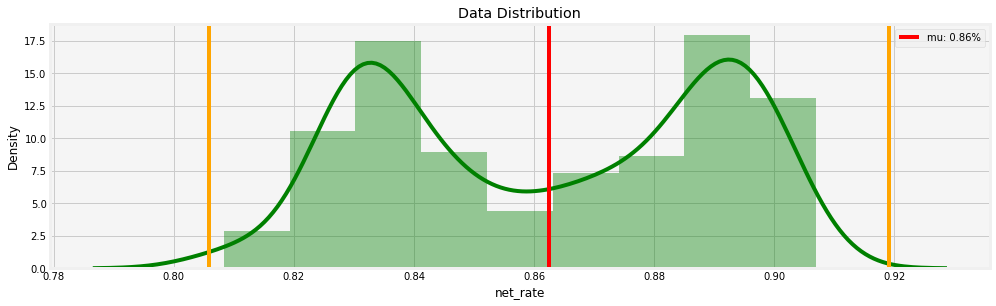

In [57]:
# Plot Distribution

plt.rcParams['axes.unicode_minus']=False
plt.rcParams['figure.figsize'] = (15.0, 4.5) # set the size of figure
plt.subplot(facecolor = "whitesmoke") # set the background color

sns.distplot(df['net_rate'],color='g')

plt.title("Data Distribution")
plt.xlabel("net_rate")

mean = np.mean(df['net_rate'])
std = np.std(df['net_rate'])
plt.axvline(x=mean, color='r', linestyle='-', label="mu: {0:.2f}%".format(mean))
plt.axvline(x=mean+2*std, color='orange', linestyle='-')
plt.axvline(x=mean-2*std, color='orange', linestyle='-')
# plt.grid(color="k", linestyle=":") # set grid and line shape
plt.legend()
plt.show()

In [58]:
# Kurt and Skew
skew = skew(df['net_rate'])
kurt = kurtosis(df['net_rate'])
print("Skewness: {} \nKurtosis: {}".format(skew, kurt))

Skewness: -0.07346378204040781 
Kurtosis: -1.5075491539177508


Text(0, 0.5, 'seasonal')

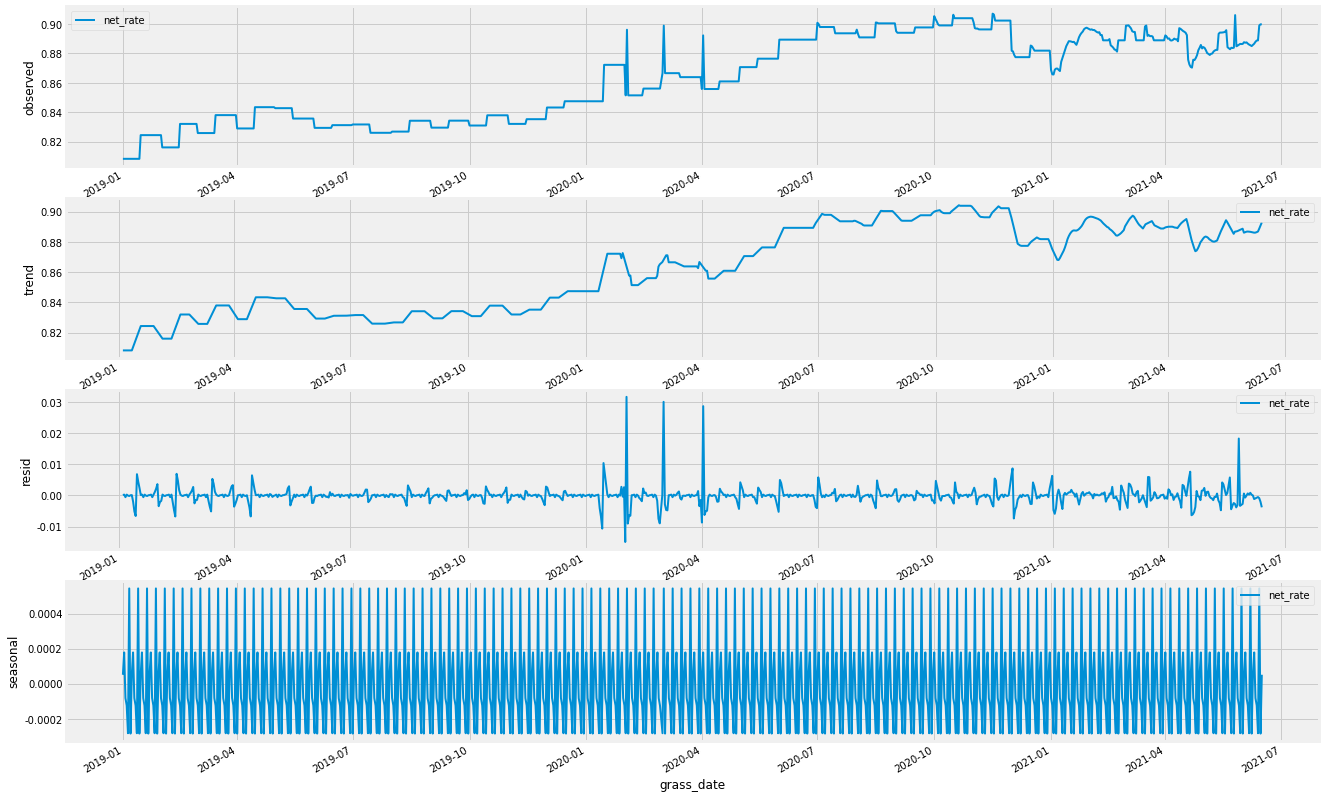

In [59]:
# Data decomposition
res = seasonal_decompose(df, model='additive',freq=7)
fig, (ax1,ax2,ax3,ax4) = plt.subplots(4,1, figsize=(20,15))
res.observed.plot(ax=ax1,linewidth=2)
ax1.set_ylabel('observed')
res.trend.plot(ax=ax2,linewidth=2)
ax2.set_ylabel('trend')
res.resid.plot(ax=ax3,linewidth=2)
ax3.set_ylabel('resid')
res.seasonal.plot(ax=ax4,linewidth=2)
ax4.set_ylabel('seasonal')

# Exponential Smoothing

In [60]:
df_val = df.loc[df.index > '2021-05-16']
df_train = df.loc[df.index <= '2021-05-16']

In [61]:
# simple exponential smoothing(one-step-ahead-prediction)
def mape(Y_actual,Y_Predicted):
    mape = np.mean(np.abs((Y_actual - Y_Predicted)/Y_actual))*100
    return mape
def sse(x, y):
    return np.sum(np.power(x-y,2))

alphas = np.arange(0.01,1,0.001)
sse_al = []
for alpha_i in alphas:
  ses_i = df.ewm(alpha = alpha_i, adjust=False).mean()
  sse_al.append(sse(df[1:].values, ses_i[:-1].values))
alpha_opt = alphas[np.argmin(sse_al)]
print(" Optimal Alpha for 1 - step forecast: {:.3f}".format(alpha_opt))

 Optimal Alpha for 1 - step forecast: 0.632


            net_rate  net_rate_exp
grass_date                        
2019-01-01  0.808311      0.808311
2019-01-02  0.808311      0.808311
2019-01-03  0.808311      0.808311
2019-01-04  0.808311      0.808311
2019-01-05  0.808311      0.808311
...              ...           ...
2021-06-11  0.887833      0.887229
2021-06-12  0.888724      0.888174
2021-06-13  0.888804      0.888572
2021-06-14  0.898944      0.895127
2021-06-15  0.899736      0.898040

[896 rows x 2 columns]


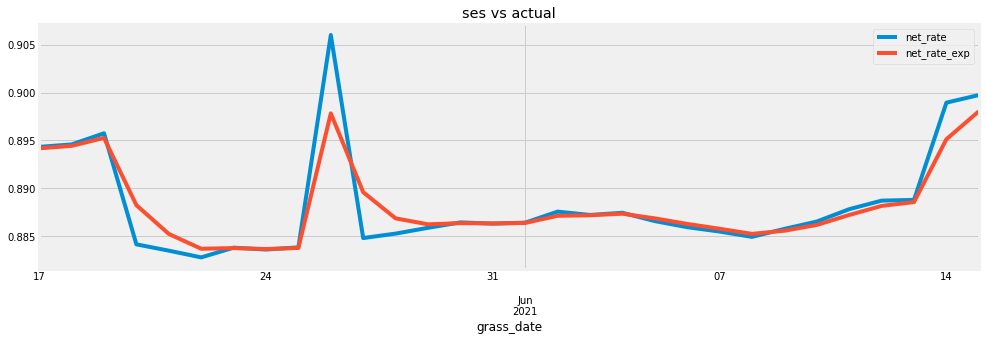

In [62]:
test_inputs = df_val['net_rate']['2021-06-16']
y = df['net_rate'][:len(df)-1]
y = y.reset_index(drop=True)

a = alpha_opt

lt_manual = [y[0]] # l0 = first observation
prediction=[] # obtain prediction values
count=0
for t in range(1,len(y)+1):
    count=count+1
    # Calculate smoothed value at time t
    if t < len(y):
        l_t = a*y[t]+(1-a)*lt_manual[t-1]
        lt_manual.append(l_t)
    else:
        yp=l_t
        pred = a*yp+(1-a)*lt_manual[t-1] # make prediction
        prediction.append(pred)

df2 = df1[1:]
df2.set_index('grass_date',inplace=True)
df2 = df2.sort_index()
df2['net_rate_exp'] = lt_manual
print(df2)
df2[len(df_train):len(df)-1].plot(title='ses vs actual')

In [63]:
actual = test_inputs.copy()
d = {'grass_date':'2021-06-16', 'actual': [actual], 'prediction': prediction}
result = pd.DataFrame(d)
result.set_index(['grass_date'], inplace=True)
result

,actual,prediction
grass_date,,
2021-06-16,0.899733,0.89804


In [64]:
# check graph
# ses = df.ewm(alpha=alpha_opt, adjust=False).mean()[len(df_train):len(df)-1]
# result=df_val.copy()
# result['ses'] = ses
# result.plot(title='ses vs actual')

# Split data

In [65]:
df_val = df.loc[df.index > '2021-05-16']
df_train = df.loc[df.index <= '2021-05-16']

In [66]:
# Normalization
# norm = MinMaxScaler(feature_range = (0,1))
# df_array = norm.fit_transform(df)

In [97]:
df_array = df_train.to_numpy()
day=60 # train and 1 output
x_train = []
y_train = []
for i in range(day,len(df_array)):
  x_train.append(df_array[i-day:i,0])
  y_train.append(df_array[i,0])
x_train, y_train = np.array(x_train), np.array(y_train)

# Reshaping
x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))

# LSTM

In [98]:
# parameter
drop = 0.2
epochs = 50
batch_size = 32

In [99]:
# Initialising LSTM
model = Sequential()

# First layer(input)
model.add(LSTM(units=50, return_sequences=True, input_shape = (x_train.shape[1],1))) # return_sequences=True because we are using LSTM
model.add(Dropout(drop))

# Second layer
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(drop))

# Third layer
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(drop))

# Fourth layer
model.add(LSTM(units=50))
model.add(Dropout(drop))

# Output layer
model.add(Dense(units=1))

# Optimizer
model.compile(optimizer='adam', loss='mean_squared_error')

# Fitting
model.fit(x_train,y_train, epochs=epochs, batch_size=batch_size)

Epoch 1/50
26/26 [==============================] - 6s 17ms/step - loss: 0.2826
Epoch 2/50
26/26 [==============================] - 0s 12ms/step - loss: 0.0128
Epoch 3/50
26/26 [==============================] - 0s 12ms/step - loss: 0.0090
Epoch 4/50
26/26 [==============================] - 0s 12ms/step - loss: 0.0075
Epoch 5/50
26/26 [==============================] - 0s 12ms/step - loss: 0.0068
Epoch 6/50
26/26 [==============================] - 0s 12ms/step - loss: 0.0060
Epoch 7/50
26/26 [==============================] - 0s 12ms/step - loss: 0.0085
Epoch 8/50
26/26 [==============================] - 0s 12ms/step - loss: 0.0063
Epoch 9/50
26/26 [==============================] - 0s 12ms/step - loss: 0.0064
Epoch 10/50
26/26 [==============================] - 0s 12ms/step - loss: 0.0058
Epoch 11/50
26/26 [==============================] - 0s 12ms/step - loss: 0.0054
Epoch 12/50
26/26 [==============================] - 0s 12ms/step - loss: 0.0058
Epoch 13/50
26/26 [==================

**Prediction**

In [100]:
df_total = pd.concat((df_train,df_val),axis=0)
inputs = df_total[len(df_total)-len(df_val)-day:].to_numpy() # inputs start #day before validation set start
inputs = inputs.reshape(-1,1)
# inputs = norm.fit_transform(inputs)
x_test = []
for i in range(day,day+len(df_val)):
  x_test.append(inputs[i-day:i,0])
x_test = np.array(x_test)
x_test = np.reshape(x_test,(x_test.shape[0],x_test.shape[1],1))

# Make prediction
prediction = model.predict(x_test)

# Inverse normalization
# prediction = norm.inverse_transform(prediction)

prediction = pd.DataFrame(prediction)
prediction.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31 entries, 0 to 30
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       31 non-null     float32
dtypes: float32(1)
memory usage: 252.0 bytes


In [101]:
# Compare Table
result = df_val.copy()
result['prediction'] = prediction.values
print(result)

            net_rate  prediction
grass_date                      
2021-05-17  0.894331    0.886902
2021-05-18  0.894587    0.886974
2021-05-19  0.895750    0.887076
2021-05-20  0.884166    0.887206
2021-05-21  0.883507    0.887357
2021-05-22  0.882807    0.887517
2021-05-23  0.883819    0.887676
2021-05-24  0.883623    0.887823
2021-05-25  0.883853    0.887952
2021-05-26  0.905999    0.888059
2021-05-27  0.884821    0.888151
2021-05-28  0.885287    0.888234
2021-05-29  0.885890    0.888308
2021-05-30  0.886456    0.888372
2021-05-31  0.886326    0.888426
2021-06-01  0.886429    0.888469
2021-06-02  0.887579    0.888503
2021-06-03  0.887232    0.888527
2021-06-04  0.887458    0.888543
2021-06-05  0.886591    0.888553
2021-06-06  0.885958    0.888557
2021-06-07  0.885499    0.888557
2021-06-08  0.884946    0.888552
2021-06-09  0.885778    0.888542
2021-06-10  0.886545    0.888528
2021-06-11  0.887833    0.888510
2021-06-12  0.888724    0.888489
2021-06-13  0.888804    0.888468
2021-06-14

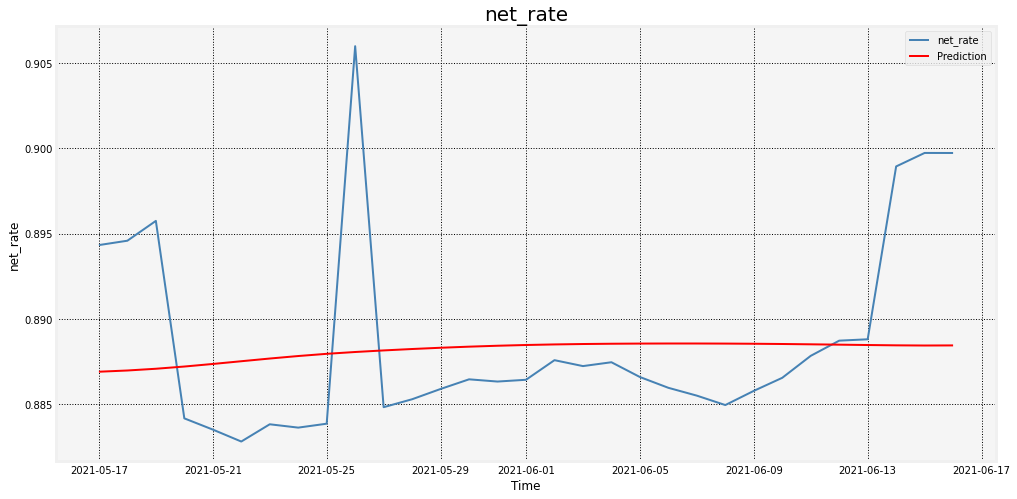

In [102]:
# Plot Data
plt.style.use('fivethirtyeight')
%matplotlib inline

plt.rcParams['axes.unicode_minus']=False
plt.rcParams['figure.figsize'] = (15.0, 8) # set the size of figure
plt.subplot(facecolor = "whitesmoke") # set the background color
plt.plot(result['net_rate'],label = 'net_rate',color="steelblue", linestyle="-", linewidth=2.0) # plot with set the line width,shape and color
plt.plot(result['prediction'], label = 'Prediction', color="Red", linewidth=2.0)
plt.legend()

plt.xlabel("Time")
plt.ylabel("net_rate")
plt.title("net_rate", fontsize = 20)
plt.grid(color="k", linestyle=":") # set grid and line shape

# plt.savefig('Daily cases.png')
plt.show()

# Model